# Расчетно-графическое домашнее задание

### Выполнил: Александров А. Н., ИУ8-104
### Вариант: 1

## Задание
Задана платежная матрица прямоугольной игры с нулевой суммой.


| 4  | -3 | 5  | 6  | 4 |
|:--:|:--:|:--:|:--:|:-:|
| 6  | 5  | -3 | 4  | 7 |
| 6  | 5  | -3 | -3 | 5 |
| -3 | -3 | 4  | 4  | 4 |
| 7  | 6  | 4  | 5  | 6 |


1. Нормализовать матрицу (привести к матрице с неотрицательными элементами) и свести исходную игру к матричной игре 2×2 следующими способами:
   - [x] поглощением доминируемых стратегий;
   - [x] удалением NBR-стратегий (Never Best Response).
2. Найти смешанные стратегии игроков следующими методами:
   - [x] графоаналитическим;
   - [ ] аналитическим (матричным);
   - [ ] графически (задача ЛП);
   - [x] симплекс-методом (задача ЛП).
3. Рассчитать цену игры для исходной матрицы.


In [1]:
import json
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from game_theory.utils.matrix_games.mixed_strategies import check_resulted_game_price, get_resulted_mixed_strategies
from game_theory.utils.matrix_games.game_matrix import GameMatrix
from game_theory.utils.simplex.dual_problem import DualProblem
from game_theory.utils.simplex.simplex_problem import SimplexProblem

logging.basicConfig(level=logging.INFO, format='%(message)s')

In [2]:
# Входная матрица прямоугольной игры с нулевой суммой.
matrix = np.array(
    [
        [4, -3, 5, 6, 4],
        [6, 5, -3, 4, 7],
        [6, 5, -3, -3, 5],
        [-3, -3, 4, 4, 4],
        [7, 6, 4, 5, 6],
    ],
    dtype=int,
)

game_matrix = GameMatrix(matrix)
game_matrix

+---------------------------------------------------------+
|               Таблица стратегий (игрока А)              |
+----------------+----+----+----+----+----+---------------+
|   Стратегии    | b1 | b2 | b3 | b4 | b5 | MIN выигрыш A |
+----------------+----+----+----+----+----+---------------+
|       a1       | 4  | -3 | 5  | 6  | 4  |       -3      |
|       a2       | 6  | 5  | -3 | 4  | 7  |       -3      |
|       a3       | 6  | 5  | -3 | -3 | 5  |       -3      |
|       a4       | -3 | -3 | 4  | 4  | 4  |       -3      |
|       a5       | 7  | 6  | 4  | 5  | 6  |       4       |
| MAX проигрыш B | 7  | 6  | 5  | 6  | 7  |               |
+----------------+----+----+----+----+----+---------------+

### 1. Нормализация матрицы. Уменьшение размерности исходной матричной игры

In [3]:
game_matrix.normalize_matrix()
game_matrix

+---------------------------------------------------------+
|               Таблица стратегий (игрока А)              |
+----------------+----+----+----+----+----+---------------+
|   Стратегии    | b1 | b2 | b3 | b4 | b5 | MIN выигрыш A |
+----------------+----+----+----+----+----+---------------+
|       a1       | 7  | 0  | 8  | 9  | 7  |       0       |
|       a2       | 9  | 8  | 0  | 7  | 10 |       0       |
|       a3       | 9  | 8  | 0  | 0  | 8  |       0       |
|       a4       | 0  | 0  | 7  | 7  | 7  |       0       |
|       a5       | 10 | 9  | 7  | 8  | 9  |       7       |
| MAX проигрыш B | 10 | 9  | 8  | 9  | 10 |               |
+----------------+----+----+----+----+----+---------------+

In [4]:
print(f"Нижняя цена игры:  {game_matrix.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {game_matrix.highest_game_price[1]}")

Нижняя цена игры:  7
Верхняя цена игры: 8


#### 1.1. Поглощение доминируемых стратегий
<u>Опр. **Доминирующая (поглощающая) строка**</u> содержит элементы $\geq$ элементам другой строки (поглощаемой).

<u>Опр. **Доминирующий (поглощающая) столбец**</u> содержит элементы $\leq$ элементам другого столбца (поглощаемого).

In [5]:
dominant_reduced_game: GameMatrix = game_matrix.reduce_dimension(method='dominant_absorption')
dominant_reduced_game

Поглощение стратегии a3 доминирующей стратегией a2
Поглощение стратегии a4 доминирующей стратегией a1
Поглощение стратегии b1 доминирующей стратегией b2
Поглощение стратегии b4 доминирующей стратегией b3
Поглощение стратегии b5 доминирующей стратегией b2
Поглощение стратегии a2 доминирующей стратегией a5


+------------------------------------------+
|       Таблица стратегий (игрока А)       |
+----------------+----+----+---------------+
|   Стратегии    | b2 | b3 | MIN выигрыш A |
+----------------+----+----+---------------+
|       a1       | 0  | 8  |       0       |
|       a5       | 9  | 7  |       7       |
| MAX проигрыш B | 9  | 8  |               |
+----------------+----+----+---------------+

In [6]:
print(f"Нижняя цена игры:  {dominant_reduced_game.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {dominant_reduced_game.highest_game_price[1]}")

Нижняя цена игры:  7
Верхняя цена игры: 8


#### 1.2. Удаление NBR-стратегий

<u>Опр. **NBR-строка**</u> - строка, которая объективно не будет разыгрываться игроком A для всех наперёд фиксированных стратегий B.

<u>Опр. **NBR-столбец**</u> - столбец, который объективно не будет разыгрываться игроком B для всех наперёд фиксированных стратегий A.

In [7]:
# Вычеркиваем столбцы и строки, которые мы точно не выберем при фиксированной стратегии.
nbr_reduced_game: GameMatrix = game_matrix.reduce_dimension(method='nbr_drop')
nbr_reduced_game

Удаление NBR-стратегий ['a3', 'a4']
Удаление NBR-стратегий ['b1', 'b4', 'b5']
Удаление NBR-стратегий ['a2']


+------------------------------------------+
|       Таблица стратегий (игрока А)       |
+----------------+----+----+---------------+
|   Стратегии    | b2 | b3 | MIN выигрыш A |
+----------------+----+----+---------------+
|       a1       | 0  | 8  |       0       |
|       a5       | 9  | 7  |       7       |
| MAX проигрыш B | 9  | 8  |               |
+----------------+----+----+---------------+

In [8]:
print(f"Нижняя цена игры:  {nbr_reduced_game.lowest_game_price[1]}\n"
      f"Верхняя цена игры: {nbr_reduced_game.highest_game_price[1]}")

Нижняя цена игры:  7
Верхняя цена игры: 8


In [9]:
assert dominant_reduced_game == nbr_reduced_game
reduced_game: GameMatrix = nbr_reduced_game

### 2. Нахождение смешанных стратегий и цены игры

$S_A = p_1 + p_2 + ... + p_n$ - смешанная стратегия игрока A.

$S_B = q_1 + q_2 + ... + q_m$ - смешанная стратегия игрока B.

#### 2.1. Графоаналитический метод

##### 2.1.1. Для игрока A.
Пусть
- $x_1$ - вероятность выбора игроком A стратегии $a_1$.
- $x_5 = 1 - x_1$ - вероятность выбора игроком A стратегии $a_5$.

Ожидаемый выигрыш A при реализации стратегии $b_2$:

$PA_{b2} = c_{12}x_{1} + c_{52}x_5 = (c_{12} - c_{52})x_5 + c_{52}$

Ожидаемый выигрыш A при реализации стратегии $b_3$:

$PA_{b3} = c_{13}x_{1} + c_{53}x_5 = (c_{13} - c_{53})x_5 + c_{53}$

Оптимальная стратегия A: $PA_{b2} = PA_{b3}$

In [10]:
(a, b), (c, d) = reduced_game.matrix.tolist()
PA_b_first = lambda x: (a - c) * x + c
PA_b_second = lambda x: (b - d) * x + d

# Находим точку пересечения решая систему Ax = b.
PA_A = np.array([
    [-(a - c), 1],
    [-(b - d), 1],
])
PA_b = np.array([c, d])
(x_intersect, y_intersect) = np.linalg.solve(PA_A, PA_b)

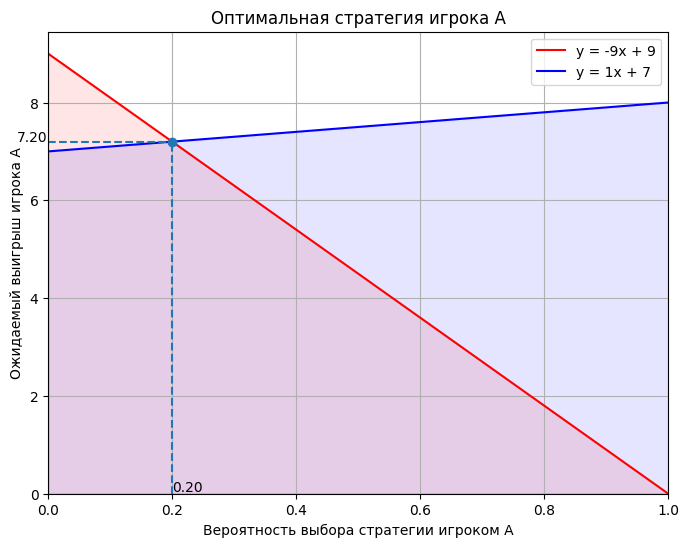

In [11]:
# Отрисовка графиков пересечения.
X = np.linspace(0, 1, 50)
PA_b_first_y = PA_b_first(X)
PA_b_second_y = PA_b_second(X)

plt.figure(figsize=(8, 6))
plt.title("Оптимальная стратегия игрока A")
plt.plot(X, PA_b_first_y, label=f"y = {a - c}x + {c}", color="red")
plt.plot(X, PA_b_second_y, label=f"y = {b - d}x + {d}", color="blue")

# Точка пересечения.
plt.plot(x_intersect, y_intersect, "o")
# Проекции точки пересечения на оси.
plt.vlines(x_intersect, min(PA_b_first_y), y_intersect, linestyles='dashed')
plt.hlines(y_intersect, min(X), x_intersect, linestyles='dashed')
# Ограничение [0, 1] - вероятность.
plt.xlim(0, 1)
# Ограничение на нормализованные элементы матрицы.
plt.ylim(0, None)
# Подписи осей.
plt.xlabel("Вероятность выбора стратегии игроком A")
plt.ylabel("Ожидаемый выигрыш игрока A")
# Сегменты под графиками.
plt.fill_between(X, PA_b_first_y, color='red', alpha=0.1)
plt.fill_between(X, PA_b_second_y, color='blue', alpha=0.1)
# Отображение значений координат точки пересечения на осях
plt.text(x_intersect, 0.05, f'{x_intersect:.2f}')
plt.text(-0.05, y_intersect, f'{y_intersect:.2f}')

plt.legend()
plt.grid(True)

In [12]:
# Смешанные стратегии игрока A и цена игры.
assert check_resulted_game_price(reduced_game, y_intersect)
get_resulted_mixed_strategies(
    player_labels=game_matrix.player_a_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_a_strategy_labels,
        [x_intersect, 1 - x_intersect],
    )),
    player_name="A",
)

Цена игры: 7 <= 7.200 <= 8


a1,a2,a3,a4,a5
0.20,0.00,0.00,0.00,0.80


##### 2.1.2. Для игрока B.
Пусть
- $y_2$ - вероятность выбора игроком B стратегии $b_2$.
- $y_3 = 1 - y_2$ - вероятность выбора игроком B стратегии $b_3$.

Ожидаемый проигрыш B при реализации стратегии $a_1$:

$PB_{a1} = c_{12}y_2 + c_{13}y_3 = (c_{12} - c_{13})y_2 + c_{13}$

Ожидаемый проигрыш B при реализации стратегии $a_5$:

$PB_{a5} = c_{52}y_2 + c_{53}y_3 = (c_{52} - c_{53})y_2 + c_{53}$

Оптимальная стратегия A: $PB_{a1} = PB_{a5}$

In [13]:
(a, b), (c, d) = reduced_game.matrix.tolist()
PB_a_first = lambda x: (a - b) * x + b
PB_a_second = lambda x: (c - d) * x + d

# Находим точку пересечения решая систему Ax = b.
PB_A = np.array([
    [-(a - b), 1],
    [-(c - d), 1],
])
PB_b = np.array([b, d])
(x_intersect, y_intersect) = np.linalg.solve(PB_A, PB_b)

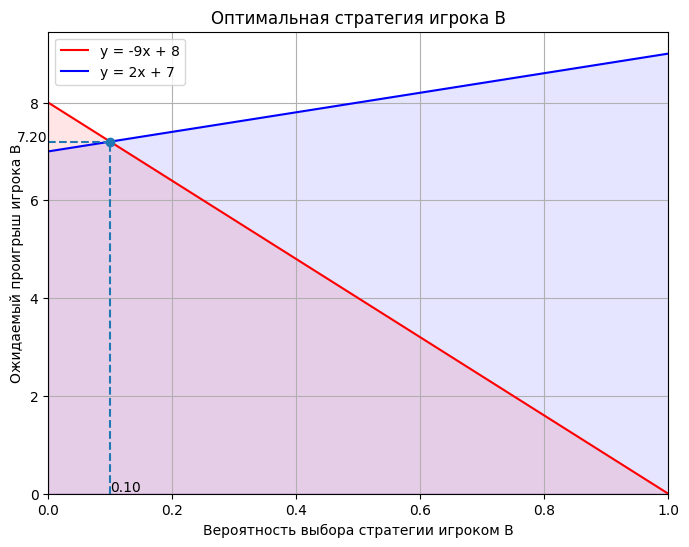

In [14]:
# Отрисовка графиков пересечения.
X = np.linspace(0, 1, 50)
PB_a_first_y = PB_a_first(X)
PB_a_second_y = PB_a_second(X)

plt.figure(figsize=(8, 6))
plt.title("Оптимальная стратегия игрока B")
plt.plot(X, PB_a_first_y, label=f"y = {a - c}x + {b}", color="red")
plt.plot(X, PB_a_second_y, label=f"y = {c - d}x + {d}", color="blue")

# Точка пересечения.
plt.plot(x_intersect, y_intersect, "o")
# Проекции точки пересечения на оси.
plt.vlines(x_intersect, min(PB_a_first_y), y_intersect, linestyles='dashed')
plt.hlines(y_intersect, min(X), x_intersect, linestyles='dashed')
# Ограничение [0, 1] - вероятность.
plt.xlim(0, 1)
# Ограничение на нормализованные элементы матрицы.
plt.ylim(0, None)
# Подписи осей.
plt.xlabel("Вероятность выбора стратегии игроком B")
plt.ylabel("Ожидаемый проигрыш игрока B")
# Сегменты под графиками.
plt.fill_between(X, PB_a_first_y, color='red', alpha=0.1)
plt.fill_between(X, PB_a_second_y, color='blue', alpha=0.1)
# Отображение значений координат точки пересечения на осях.
plt.text(x_intersect, 0.05, f'{x_intersect:.2f}')
plt.text(-0.05, y_intersect, f'{y_intersect:.2f}')

plt.legend()
plt.grid(True)

In [15]:
# Смешанные стратегии игрока B и цена игры.
assert check_resulted_game_price(reduced_game, y_intersect)
get_resulted_mixed_strategies(
    player_labels=game_matrix.player_b_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_b_strategy_labels,
        [x_intersect, 1 - x_intersect],
    )),
    player_name="B",
)

Цена игры: 7 <= 7.200 <= 8


b1,b2,b3,b4,b5
0.00,0.10,0.90,0.00,0.00


#### 2.2. Аналитический (матричный) метод

In [16]:
# TODO: МА рассказывал на 2 лекции

#### 2.3. Графический метод (задача ЛП)

In [17]:
# TODO: надо достать старую КР с 3 семестра и посмотреть оформление 

#### 2.4. Симплекс-метод (задача ЛП)

<div style="text-align:center;">
    <img src="img/system_matrix_game.png" alt="system_matrix_game" width="450" height="330">
    <img src="img/LP_task_01.png" alt="LP_task_01" width="450" height="330">
</div>
<div style="text-align:center;">
    <img src="img/LP_task_02.png" alt="LP_task_02" width="450" height="330">
</div>


In [18]:
# Подготовка входных данных.
n_rows, n_cols = reduced_game.matrix.shape
input_data = {
    "obj_func_coffs": [1] * n_cols,
    "constraint_system_lhs": reduced_game.matrix.tolist(),
    "constraint_system_rhs": [1] * n_rows,
    "func_direction": "max"
}

input_path = Path('input_simplex.json')
_ = input_path.write_text(json.dumps(input_data))

##### 2.4.1. Двойственная задача ЛП для игрока A

In [19]:
player_a_problem = DualProblem(input_path)

F = cx -> min,
Ax >= b,
x1, x2, ..., xn >= 0
C = [1 1]
A =
[[0 9]
 [8 7]],
b^T = [1 1].


In [20]:
player_a_solution = player_a_problem.solve()
player_a_var_values, player_a_target_function_value = player_a_solution

Процесс решения:
Поиск опорного решения: 
Исходная симплекс-таблица:
+----+---------+---------+---------+
|    |   Si0   |    x1   |    x2   |
+----+---------+---------+---------+
| x3 | -1.0000 |  0.0000 | -9.0000 |
| x4 | -1.0000 | -8.0000 | -7.0000 |
| F  |  0.0000 | -1.0000 | -1.0000 |
+----+---------+---------+---------+
Разрешающая строка: x3
Разрешающий столбец: x2
+----+---------+---------+---------+
|    |   Si0   |    x1   |    x3   |
+----+---------+---------+---------+
| x2 |  0.1111 | -0.0000 | -0.1111 |
| x4 | -0.2222 | -8.0000 | -0.7778 |
| F  |  0.1111 | -1.0000 | -0.1111 |
+----+---------+---------+---------+
Разрешающая строка: x4
Разрешающий столбец: x1
+----+--------+---------+---------+
|    |  Si0   |    x4   |    x3   |
+----+--------+---------+---------+
| x2 | 0.1111 | -0.0000 | -0.1111 |
| x1 | 0.0278 | -0.1250 |  0.0972 |
| F  | 0.1389 | -0.1250 | -0.0139 |
+----+--------+---------+---------+
Опорное решение найдено!
x4 = x3 = 0, 
x2 = 0.111, x1 = 0.028
Целев

In [21]:
# Смешанные стратегии игрока A и цена игры.
game_price_value = 1 / player_a_target_function_value
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

player_a_mixed_strategies = [var_value * game_price_value for var_value in player_a_var_values]
player_a_mixed_strategies = player_a_mixed_strategies[:len(reduced_game.player_a_strategy_labels)]
get_resulted_mixed_strategies(
    player_labels=game_matrix.player_a_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_a_strategy_labels,
        player_a_mixed_strategies,
    )),
    player_name="A",
)

Цена игры: 7 <= 7.200 <= 8


a1,a2,a3,a4,a5
0.20,0.00,0.00,0.00,0.80


##### 2.4.2. Прямая задача ЛП для игрока B

In [22]:
player_b_problem = SimplexProblem(input_path)
player_b_problem

Условие задачи:
Найти вектор x = (x1,x2,..., xn)^T как решение след. задачи:
F = cx -> max,
Ax <= b,
x1,x2, ..., xn >= 0
C = [-1 -1],
A =
[[0 8]
 [9 7]],
b^T = [1 1].

In [23]:
player_b_solution = player_b_problem.solve()
player_b_var_values, player_b_target_function_value = player_b_solution

Процесс решения:
Поиск опорного решения: 
Исходная симплекс-таблица:
+----+--------+--------+--------+
|    |  Si0   |   x1   |   x2   |
+----+--------+--------+--------+
| x3 | 1.0000 | 0.0000 | 8.0000 |
| x4 | 1.0000 | 9.0000 | 7.0000 |
| F  | 0.0000 | 1.0000 | 1.0000 |
+----+--------+--------+--------+
Опорное решение найдено!
x1 = x2 = 0, 
x3 = 1.000, x4 = 1.000
Целевая функция: F = 0.000
Поиск оптимального решения:
Разрешающая строка: x4
Разрешающий столбец: x1
+----+---------+---------+--------+
|    |   Si0   |    x4   |   x2   |
+----+---------+---------+--------+
| x3 |  1.0000 | -0.0000 | 8.0000 |
| x1 |  0.1111 |  0.1111 | 0.7778 |
| F  | -0.1111 | -0.1111 | 0.2222 |
+----+---------+---------+--------+
Разрешающая строка: x3
Разрешающий столбец: x2
+----+---------+---------+---------+
|    |   Si0   |    x4   |    x3   |
+----+---------+---------+---------+
| x2 |  0.1250 | -0.0000 |  0.1250 |
| x1 |  0.0139 |  0.1111 | -0.0972 |
| F  | -0.1389 | -0.1111 | -0.0278 |
+----+--

In [24]:
# Смешанные стратегии игрока B и цена игры.
game_price_value = 1 / player_b_target_function_value
assert check_resulted_game_price(
    game_matrix=reduced_game,
    game_price_value=game_price_value,
)

player_b_mixed_strategies = [var_value * game_price_value for var_value in player_b_var_values]
player_b_mixed_strategies = player_b_mixed_strategies[:len(reduced_game.player_b_strategy_labels)]
get_resulted_mixed_strategies(
    player_labels=game_matrix.player_b_strategy_labels,
    labels_to_probability=dict(zip(
        reduced_game.player_b_strategy_labels,
        player_b_mixed_strategies,
    )),
    player_name="B",
)

Цена игры: 7 <= 7.200 <= 8


b1,b2,b3,b4,b5
0.00,0.10,0.90,0.00,0.00
